# Tic Tac Toe - Reinforcement learning

In [11]:
from tictactoe_gym_env import TicTacToeEnv
import numpy as np
from collections import defaultdict
from matplotlib import pyplot as plt
from IPython import display
import random
import pickle

## Plot functions

In [12]:
def plot_reward_history(reward_history, average_reward_history):
    plt.title(f"Reward history")
    # plt.plot(reward_history)
    plt.plot(average_reward_history)
    plt.show()

## Q-learning agent

In [13]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, lr=0.01, gamma=0.9, epsilon=0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = defaultdict(lambda: np.zeros(n_actions))

    def choose_action(self, state, epsilon=None):
        # Illegal moves
        self.q_table[tuple(state)][state!=0] = -100

        if epsilon is None:
            epsilon = self.epsilon
        if np.random.rand() < epsilon:
            indices = np.where(self.q_table[tuple(state)] > -100)[0]
            return np.random.choice(indices)
        else:
            max_value = np.max(self.q_table[tuple(state)])
            indices = np.where(self.q_table[tuple(state)] == max_value)[0]
            return np.random.choice(indices)

    def update_q_table(self, state, action, reward, next_state, done):
        q_value = self.q_table[tuple(state)][action]

        if done:
            target_q_value = reward
        else:
            v = self.q_table[tuple(next_state)]
            target_q_value = reward + self.gamma * np.max(v)

        new_q_value = q_value + self.lr * (target_q_value - q_value)
        self.q_table[tuple(state)][action] = new_q_value


    
    def save_q_table(self, file_path="q_table.pkl"):
        with open(file_path, 'wb') as file:
            pickle.dump(dict(self.q_table), file)

    def load_q_table(self, file_path="q_table.pkl"):
        with open(file_path, 'rb') as file:
            loaded_q_table = pickle.load(file)
        self.q_table = defaultdict(lambda: np.zeros(len(loaded_q_table[next(iter(loaded_q_table))])))
        self.q_table.update(loaded_q_table)


## Opponent strategies

In [14]:
def random_strategy(state):
    return np.random.choice(np.where(state==0)[0])


def compute_couples(values):
    couples = []
    for i in range(len(values)):
        for j in range(i+1, len(values)):
            couples.append((values[i], values[j]))
    return couples


def magic_strategy(state):
    magic_square = np.array([4, 9, 2,
                             3, 5, 7,
                             8, 1, 6])

    player_mask = state==1
    opponent_mask = state==2

    # If two opponent moves were done
    if (np.sum(opponent_mask)>=2):
        couples = compute_couples(magic_square[opponent_mask])
        for couple in couples:
            new_place = 15 - np.sum(couple)
            if 0 < new_place <= 9:
                if state[magic_square == new_place][0] == 0:
                    action = np.where(magic_square == new_place)[0][0]
                    # print("WIN")
                    return action

    # If two player moves were done
    if (np.sum(player_mask)>=2):
        couples = compute_couples(magic_square[player_mask])
        for couple in couples:
            new_place = 15 - np.sum(couple)
            if 0 < new_place <= 9:
                if state[magic_square == new_place][0] == 0:
                    action = np.where(magic_square == new_place)[0][0]
                    # print("CONTRAST")
                    return action

    if state[4] == 0:
        # print("CENTER")
        action = 4
    else:
        # print("RANDOM")
        action = np.random.choice(np.where(state==0)[0])
    return action



def agent_strategy(state, agent):
    return agent.choose_action(state, 0.)

## Training function

In [15]:
def train(env, agent, train_episodes, render = False, verbose=True):
    reward_history = []
    average_reward_history = []


    for ep in range(train_episodes):
        state, info = env.reset()
        done = False
        reward_sum = 0

        final_epsilon = 0.1

        # Constant epsilon
        # epsilon = final_epsilon

        # glie epsilon
        b = 0.8*train_episodes*final_epsilon/(1-final_epsilon) 
        epsilon = max(b/(b+ep), final_epsilon)
        
        # Epsilon decay
        # b = (1 - final_epsilon) / (0.5*train_episodes)
        # epsilon = max(1 - b*ep, final_epsilon)

        while not done:
            action = agent.choose_action(state, epsilon)
            next_state, reward, done, res, info = env.step(action) # res: None win lose draw illegal
            reward_sum += reward
            agent.update_q_table(state, action, reward, next_state, done)
                
            if render:
                print(env.render())

            state = next_state        

        if ep%1000==0:
            agent.save_q_table("q_table_.pkl")

        reward_history.append(reward_sum)
        avg = np.mean(reward_history[-100:])
        average_reward_history.append(avg)

        if verbose:
            print(f"Episode {ep} - Epsilon {epsilon:.2f} Total reward: {reward_sum:.3g} - Avg reward: {avg:.3g} - {res.upper()}")
            
    agent.save_q_table("q_table.pkl")
    plot_reward_history(reward_history, average_reward_history)


## Testing function

In [16]:
def test(env, agent, test_episodes, render=False, verbose=True):
    reward_history = []
    average_reward_history = []
    win_count = 0
    draw_count = 0
    lose_count = 0
    illegal_count = 0

    for ep in range(test_episodes):
        state, info = env.reset()
        done = False
        reward_sum = 0

        epsilon = 0
    
        while not done:
            action = agent.choose_action(state, epsilon)
            next_state, reward, done, res, info = env.step(action) # res: None win lose draw illegal
            reward_sum += reward
                
            if render:
                print(env.render())
                input()

            state = next_state        

        reward_history.append(reward_sum)
        avg = np.mean(reward_history[-100:])
        average_reward_history.append(avg)

        if res == "win":
            win_count += 1
        elif res == "draw":
            draw_count += 1
        elif res == "lose":
            lose_count += 1
        elif res == "illegal":
            illegal_count += 1

        if verbose:
            print(f"Episode {ep} - Total reward: {reward_sum:.3g} - Avg reward: {avg:.3g} - {res.upper()}")
        if render:
            input()
    
    print(f"Win rate {100*win_count/test_episodes:.2f}%")
    print(f"Lose rate {100*lose_count/test_episodes:.2f}%")
    print(f"Draw rate {100*draw_count/test_episodes:.2f}%")
    print(f"Illegal rate {100*illegal_count/test_episodes:.2f}%")

    plot_reward_history(reward_history, average_reward_history)


## Training

Episode 0 - Epsilon 1.00 Total reward: -10 - Avg reward: -10 - LOSE
Episode 1 - Epsilon 1.00 Total reward: 10 - Avg reward: 0 - WIN
Episode 2 - Epsilon 1.00 Total reward: 10 - Avg reward: 3.33 - WIN
Episode 3 - Epsilon 1.00 Total reward: -10 - Avg reward: 0 - LOSE
Episode 4 - Epsilon 1.00 Total reward: 3 - Avg reward: 0.6 - DRAW
Episode 5 - Epsilon 1.00 Total reward: 10 - Avg reward: 2.17 - WIN
Episode 6 - Epsilon 1.00 Total reward: -10 - Avg reward: 0.429 - LOSE
Episode 7 - Epsilon 1.00 Total reward: -10 - Avg reward: -0.875 - LOSE
Episode 8 - Epsilon 1.00 Total reward: -10 - Avg reward: -1.89 - LOSE
Episode 9 - Epsilon 1.00 Total reward: -10 - Avg reward: -2.7 - LOSE
Episode 10 - Epsilon 1.00 Total reward: 10 - Avg reward: -1.55 - WIN
Episode 11 - Epsilon 1.00 Total reward: -10 - Avg reward: -2.25 - LOSE
Episode 12 - Epsilon 1.00 Total reward: -10 - Avg reward: -2.85 - LOSE
Episode 13 - Epsilon 1.00 Total reward: -10 - Avg reward: -3.36 - LOSE
Episode 14 - Epsilon 1.00 Total reward: 

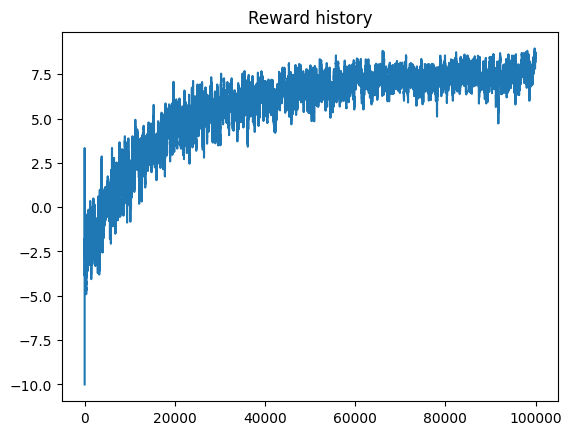

In [17]:
env = TicTacToeEnv(opponent_strategies=(random_strategy, magic_strategy))

# opponent_agent = QLearningAgent(9, 9)
# opponent_agent.load_q_table("./models/q_table_3.pkl")
# a_strategy = lambda state: agent_strategy(state, opponent_agent)
# env = TicTacToeEnv(opponent_strategies=(magic_strategy, a_strategy))

lr = 0.1
gamma = 0.9
epsilon = 0.1

train_episodes = 100_000

agent = QLearningAgent(env.n_states, env.n_actions, lr=lr, gamma=gamma, epsilon=epsilon)
# agent.load_q_table("q_table_2.pkl")

train(env, agent, train_episodes, render=False)

## Testing

Test against random_strategy:
Win rate 98.12%
Lose rate 0.00%
Draw rate 1.88%
Illegal rate 0.00%


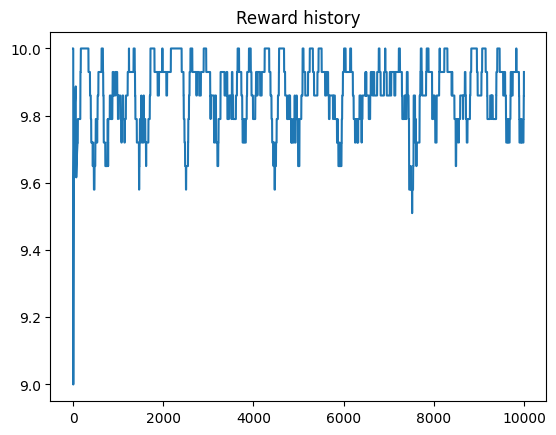


Test against random_strategy (first move):
Win rate 98.13%
Lose rate 0.00%
Draw rate 1.87%
Illegal rate 0.00%


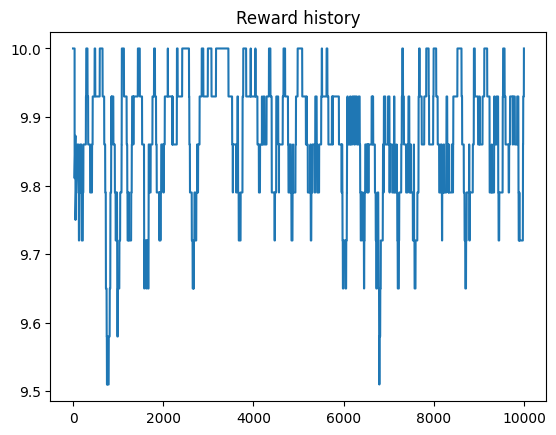


Test against random_strategy (opponent first move):
Win rate 91.49%
Lose rate 0.00%
Draw rate 8.51%
Illegal rate 0.00%


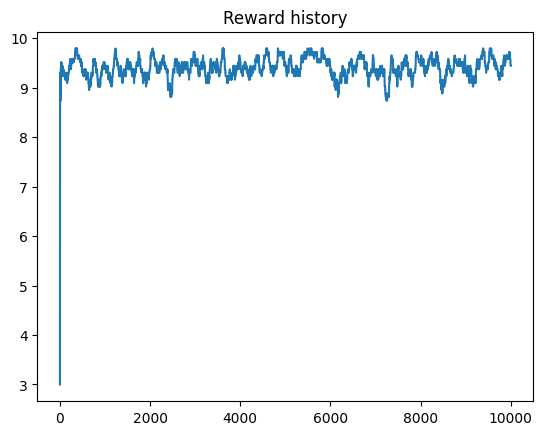


Test against magic_strategy:
Win rate 74.89%
Lose rate 0.00%
Draw rate 25.11%
Illegal rate 0.00%


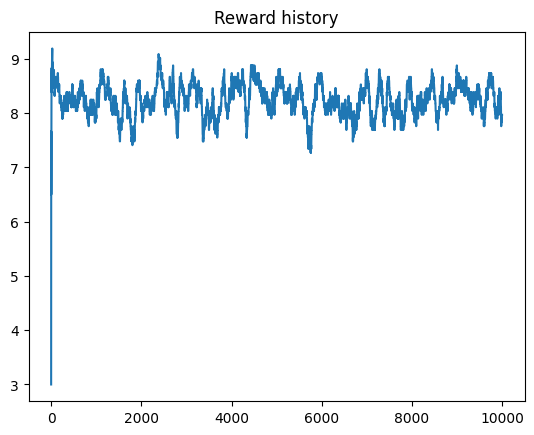


Test against magic_strategy (first move):
Win rate 75.15%
Lose rate 0.00%
Draw rate 24.85%
Illegal rate 0.00%


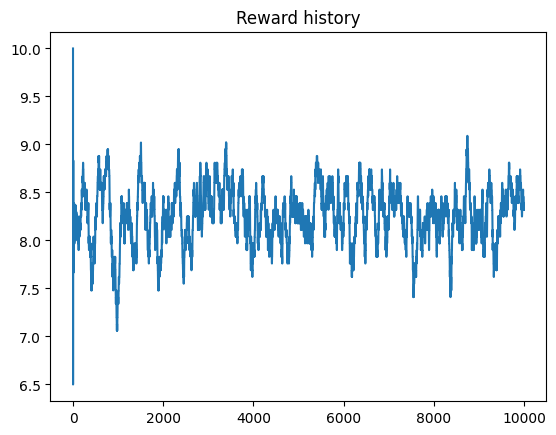


Test against magic_strategy (opponent first move):
Win rate 6.02%
Lose rate 0.00%
Draw rate 93.98%
Illegal rate 0.00%


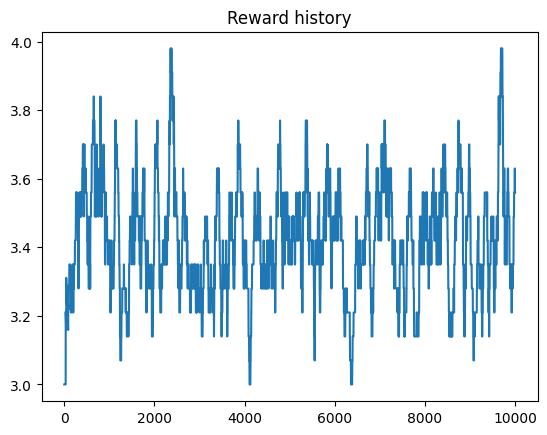

In [23]:
test_episodes = 10_000
agent = QLearningAgent(9, 9)
agent.load_q_table("./models/q_table_3.pkl")

print("Test against random_strategy:")
env = TicTacToeEnv(opponent_strategies=(random_strategy,))
test(env, agent, test_episodes, render=False, verbose=False)
print()

print("Test against random_strategy (first move):")
env = TicTacToeEnv(opponent_strategies=(random_strategy,), initial_turn=1)
test(env, agent, test_episodes, render=False, verbose=False)
print()

print("Test against random_strategy (opponent first move):")
env = TicTacToeEnv(opponent_strategies=(random_strategy,), initial_turn=2)
test(env, agent, test_episodes, render=False, verbose=False)
print()

print("Test against magic_strategy:")
env = TicTacToeEnv(opponent_strategies=(magic_strategy,))
test(env, agent, test_episodes, render=False, verbose=False)
print()

print("Test against magic_strategy (first move):")
env = TicTacToeEnv(opponent_strategies=(magic_strategy,), initial_turn=1)
test(env, agent, test_episodes, render=False, verbose=False)
print()

print("Test against magic_strategy (opponent first move):")
env = TicTacToeEnv(opponent_strategies=(magic_strategy,), initial_turn=2)
test(env, agent, test_episodes, render=False, verbose=False)
print()